# Playground for Experiments

We try to solve discrimination on the <a href=https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29>German Credit Data Set</a> used in <a href=https://ieeexplore.ieee.org/abstract/document/8452913>Verma & Rubin (2018)</a> with the model presented in <a href=http://papers.nips.cc/paper/6668-avoiding-discrimination-through-causal-reasoning>Kilbertus et al. (2017)</a>.

The first thing we try is analysing the data and try to find a useful causal model to apply the method.

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import fairensics as fr
import networkx as nx
import matplotlib.pyplot as plt
import collections as col

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from aif360.datasets import GermanDataset
from aif360.metrics import ClassificationMetric
from fairensics.data.synthetic_dataset import SyntheticDataset
from fairensics.data.decision_boundary import DecisionBoundary 
from fairensics.methods import FairDisparateImpact, AccurateDisparateImpact
from fairensics.methods import DisparateMistreatment
from fairensics.methods import PreferentialFairness
from sklearn.linear_model import LogisticRegression

#  Hide warnings of LinearSVC, LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/Users/julian/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## The data set

The data set has 20 attributes:

 - Checking account: 
     - A11: x < 0 DM
     - A12: 0 <= x < 200 DM
     - A13: x >= 200 DM
     - A14: no account
     
     
 - Credit duration in months
 
 
 - Credit history:
     - A30: no credits taken / all credits paid back duly
     - A31: all credits at this bank paid back duly
     - A32: existing credits paid back duly till now
     - A33: delay in paying off in the past
     - A34: critical account / other credits existing (not at this bank)
     
     
 - Purpose:
     - A40: car (new)
     - A41: car (used)
     - A42: furniture / equipment
     - A43: radio / television
     - A44: domestic appliance
     - A45: repairs
     - A46: education
     - A47: (vacation - but does not exist in the data set?)
     - A48: retraining
     - A49: business
     - A410: others
     
     
 - Credit amount
 
 
 - Savings account/bonds:
     - A61: x < 100 DM
     - A62: 100 <= x < 500 DM
     - A63: 500 <= x < 1000 DM
     - A64: x >= 1000 DM
     - A65: unknown / no savings account
     
     
 - Present employment since:
     - A71: unemployed
     - A72: x < 1 year
     - A73: 1 <= x < 4 years
     - A74: 4 <= x < 7 years
     - A75: x >= 7 years
     
     
 - Installment rate in percentage of disposable income
 
 
 - Personal status and sex:
     - A91: male, divorced / separated
     - A92: female, divorced / separated / married
     - A93: male, single
     - A94: male, married
     - A95: female, single
     
     
 - Other debtors / guarantors:
     - A101: none
     - A102: co-applicant
     - A103: guarantor
     
     
 - Present residence since (probably in years)
 
 
 - Property:
     - A121: real estate
     - A122: if not A121: building society savings agreement / life insurance
     - A123: if not A121 / 122: car or other, not in attribute 6
     - A124: unknown / no property
     
     
 - Age in years
 
 
 - Other installment plans:
     - A141: bank
     - A142: stores
     - A143: none
     
     
 - Housing:
     - A151: rent
     - A152: own
     - A153: for free
     
     
 - Number of existing credits at this bank
 
 
 - Job:
     - A171: unemployed / unskilled - non-resident
     - A172: unskilled - resident
     - A173: skilled employee / official
     - A174: management / self-employed / highly qualified employee / officer
     
     
 - Number of people being liable to provide maintenance for
 
 
 - Telephone:
     - A191: none
     - A192: yes, registered under the customers name
     
     
 - foreign worker:
     - A201: yes
     - A202: no
     
     
The last entry is the predicted credit score, which is the outcome we want:   
 - credit score:
     - 1: Good
     - 2: Bad

For example, Alice is requesting a loan amount of 1567 DM for a duration of 12 months for the purpose of purchasing a television, with a positive checking account balance that is smaller than 200 DM, having less than 100 DM in savings account, and having one existing credit at this bank. She duly paid existing credits at the bank till now and has no other installment plan. She possesses a car and owns a house, has been living at the present residence for one year and has a registered telephone. She is a skilled employee, working in the present employment for past four years. She is a 22-year-old married female and is a German citizen. She has one dependent and no guarantors. The recorded outcome for Alice (attribute #21) is a good credit score (example taken from <a href=https://ieeexplore.ieee.org/abstract/document/8452913>Verma & Rubin (2018)</a>).


In [2]:
attributes = ["checking account", "duration", "credit history", "purpose", "credit amount", "savings", 
              "employment (since)", "installment rate", "status and sex", "debtors/guarantors", "residence (since)",
             "property", "age", "other installment plans", "housing", "existing credits", "job", 
             "liable people", "phone", "foreign worker", "credit score"]

#alice = np.array([["A12", 12, "A32", "A43", 1567, "A61", "A74", 2, "A92", "A101", 1, "A121", 22, "A143", "A152", 1,
        # "A173", 1, "A192", "A202", 1]])

#alice_df = pd.read_table("data/german_credit/alice.data", sep="\s", names=attributes)
#alice_score = np.ravel(pd.DataFrame(alice_df["credit score"]))
#del alice_df["credit score"]

df = pd.read_table("data/german_credit/german.data", sep="\s", names=attributes, engine="python")

# extracts the credit score into its own data frame and deletes it from the imported data frame.
score = np.ravel(pd.DataFrame(df["credit score"]))
del df["credit score"]

df.head(10)

,checking account,duration,credit history,purpose,credit amount,savings,employment (since),installment rate,status and sex,debtors/guarantors,residence (since),property,age,other installment plans,housing,existing credits,job,liable people,phone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,4,A124,35,A143,A153,1,A172,2,A192,A201
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,4,A122,53,A143,A152,1,A173,1,A191,A201
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,2,A123,35,A143,A151,1,A174,1,A192,A201
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,4,A121,61,A143,A152,1,A172,1,A191,A201
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,2,A123,28,A143,A152,2,A174,1,A191,A201


In [3]:
df.tail()

,checking account,duration,credit history,purpose,credit amount,savings,employment (since),installment rate,status and sex,debtors/guarantors,residence (since),property,age,other installment plans,housing,existing credits,job,liable people,phone,foreign worker
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201
999,A12,45,A34,A41,4576,A62,A71,3,A93,A101,4,A123,27,A143,A152,1,A173,1,A191,A201
1000,A12,12,A32,A43,1567,A61,A74,2,A92,A101,1,A121,22,A143,A152,1,A173,1,A192,A202


In [4]:
score[:10]

array([1, 2, 1, 1, 2, 1, 1, 1, 1, 2])

In [5]:
df.dtypes

checking account           object
duration                    int64
credit history             object
purpose                    object
credit amount               int64
savings                    object
employment (since)         object
installment rate            int64
status and sex             object
debtors/guarantors         object
residence (since)           int64
property                   object
age                         int64
other installment plans    object
housing                    object
existing credits            int64
job                        object
liable people               int64
phone                      object
foreign worker             object
dtype: object

# Fair Classification

We build a Classifier implementing the idea from <a href=http://papers.nips.cc/paper/6668-avoiding-discrimination-through-causal-reasoning>Kilbertus et al. (2017)</a>. Since it is very difficult to set up a causal model, we restrict our model to the following features:

 - credit duration
 - credit history
 - credit amount
 - present employement since (proxy variable)
 - sex
 - age (protected attribute)
 - job
 - foreign worker
 
While it is for sure not a complete model it should be able to show if the idea the paper presents is working.

The first thing we have to do is to build a causal model graph.

The second thing we have to do is to reduce the dataset down to the needed features.

Then we can start applying the proposal from <a href=http://papers.nips.cc/paper/6668-avoiding-discrimination-through-causal-reasoning>Kilbertus et al. (2017)</a>.

### Attributes we want to use

In [6]:
attributes_short = ["status and sex", "employment (since)", "job", "credit amount", "duration", "age", 
                    "credit history", "foreign worker", "credit score"]

### Model

#### Graph

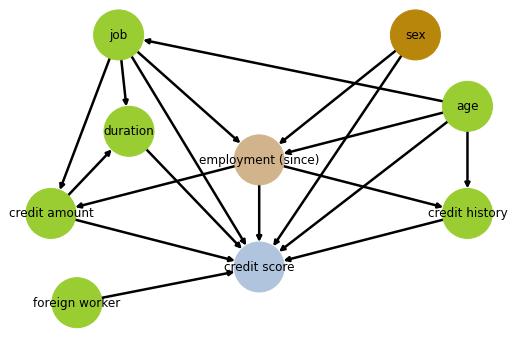

In [7]:
model = nx.DiGraph()
map(model.add_node, attributes_short)
nx.relabel_nodes(model, {"status and sex": "sex"})
# 2, 8 depend on 0:
model.add_edge("sex", "employment (since)")
model.add_edge("sex", "credit score")
# 8 depends on 1:
model.add_edge("employment (since)", "credit amount")
model.add_edge("employment (since)", "credit history")
model.add_edge("employment (since)", "credit score")
# 1, 4, 8 depend on 2:
model.add_edge("job", "employment (since)")
model.add_edge("job", "credit amount")
model.add_edge("job", "duration")
model.add_edge("job", "credit score")
# 4, 8 depend on 3:
model.add_edge("credit amount", "duration")
model.add_edge("credit amount", "credit score")
# 8 depends on 4:
model.add_edge("duration", "credit score")
# 2, 6, 8 depend on 5:
model.add_edge("age", "employment (since)")
model.add_edge("age", "job")
model.add_edge("age", "credit history")
model.add_edge("age", "credit score")
# 8 depends on 6:
model.add_edge("credit history", "credit score")
# 8 depends on 7:
model.add_edge("foreign worker", "credit score")

# now draw the graph:
pos = {"sex" : (1.5,3), 
       "employment (since)" : (0,1.25), 
       "job" : (-1.35,3),
       "credit amount" : (-2,0.5),
       "duration": (-1.25,1.65),
       "age" : (2,2),
       "credit history" : (2,0.5),
       "foreign worker" : (-1.75,-0.75),
       "credit score" : (0,-0.25)}

colors = ["darkgoldenrod", "tan", "lightsteelblue","yellowgreen", "yellowgreen", "yellowgreen", 
          "yellowgreen", "yellowgreen", "yellowgreen"]

plt.figure(figsize=(7,4.5)) 
nx.draw(model, pos=pos, with_labels=True, node_color=colors, node_size=2500, width=2.5)
#nx.draw_planar(model, with_labels=True, node_color=colors, node_size=2500, width=2.5)

#plt.savefig("graph.png")
plt.show()

#### Graph after intervention

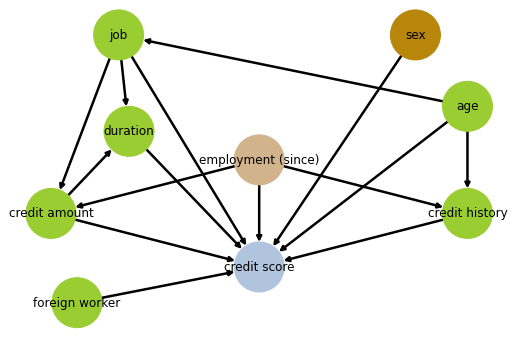

In [8]:
model.remove_edges_from([("sex", "employment (since)"), ("job", "employment (since)"), ("age", "employment (since)")])

plt.figure(figsize=(7,4.5)) 
nx.draw(model, pos=pos, with_labels=True, node_color=colors, node_size=2500, width=2.5)
#plt.savefig("graph_intervention.png")
plt.show()

### Dataset preparation

#### Preprocessing data to fit classification

We first copy the large data set and the score and remove the attributes we do not want to use in our model.

In [9]:
df_short = df.copy()
score_short = score.copy()
df_short.drop([elem for elem in attributes if not elem in attributes_short], inplace=True, axis=1)
df_short.head(10)

,duration,credit history,credit amount,employment (since),status and sex,age,job,foreign worker
0,6,A34,1169,A75,A93,67,A173,A201
1,48,A32,5951,A73,A92,22,A173,A201
2,12,A34,2096,A74,A93,49,A172,A201
3,42,A32,7882,A74,A93,45,A173,A201
4,24,A33,4870,A73,A93,53,A173,A201
5,36,A32,9055,A73,A93,35,A172,A201
6,24,A32,2835,A75,A93,53,A173,A201
7,36,A32,6948,A73,A93,35,A174,A201
8,12,A32,3059,A74,A91,61,A172,A201
9,30,A34,5234,A71,A94,28,A174,A201


check shape to make sure we did everything correct.

In [10]:
df_short.shape

(1001, 8)

check if our model suggests the same columns.

In [11]:
list(model.predecessors("credit score"))

['sex',
 'employment (since)',
 'job',
 'credit amount',
 'duration',
 'age',
 'credit history',
 'foreign worker']

We map the columns of our data set from categorical to numerical data. This way, we can use a standard LogisticRegression classifier on our data set.

We could also use a binary split for every categorical column but then it would be harder to calculate probabilities.

In [12]:
col.Counter(df_short["status and sex"])

Counter({'A93': 548, 'A92': 311, 'A91': 50, 'A94': 92})

In [13]:
# male = 0, female = 1
status_map = {'A91': 0, 'A93': 0, 'A94': 0, 'A92': 1, 'A95': 1}
history_map = {'A30': 0, 'A31': 1, 'A32': 2, 'A33': 3, 'A34': 4}
employment_map = {'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}
job_map = {'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}
foreign_map = {'A201': 0, 'A202': 1}

df_short['sex'] = df_short['status and sex'].replace(status_map).astype(int)
df_short['credit history'] = df_short['credit history'].replace(history_map).astype(int)
df_short['employment (since)'] = df_short['employment (since)'].replace(employment_map).astype(int)
df_short['job'] = df_short['job'].replace(job_map).astype(int)
df_short['foreign worker'] = df_short['foreign worker'].replace(foreign_map).astype(int)
df_short.drop("status and sex", inplace=True, axis=1)
df_short.head(10)

,duration,credit history,credit amount,employment (since),age,job,foreign worker,sex
0,6,4,1169,4,67,2,0,0
1,48,2,5951,2,22,2,0,1
2,12,4,2096,3,49,1,0,0
3,42,2,7882,3,45,2,0,0
4,24,3,4870,2,53,2,0,0
5,36,2,9055,2,35,1,0,0
6,24,2,2835,4,53,2,0,0
7,36,2,6948,2,35,3,0,0
8,12,2,3059,3,61,1,0,0
9,30,4,5234,0,28,3,0,0


Again, check shape to see if we did everything right.

In [14]:
df_short.shape

(1001, 8)

In [15]:
col.Counter(df_short["sex"])

Counter({0: 690, 1: 311})

The last row is an individual called Alice introduced by  <a href=https://ieeexplore.ieee.org/abstract/document/8452913>Verma & Rubin (2018)</a>.

We remove it from the data set so that we can use it for controlling the classifier later on.

In [16]:
alice_df = df_short.loc[len(df_short.index) - 1, :]
alice_df_fair = alice_df.copy()
alice_score = score_short[len(df_short.index) - 1]
df_short.drop(len(df_short.index) - 1, inplace=True)
score_short = np.delete(score_short, len(df_short.index) - 1, 0)

In [17]:
df_short.shape

(1000, 8)

In [18]:
display(alice_df)

duration                12
credit history           2
credit amount         1567
employment (since)       3
age                     22
job                      2
foreign worker           1
sex                      1
Name: 1000, dtype: int64

Plot duration and age estimated pdfs, just for fun.

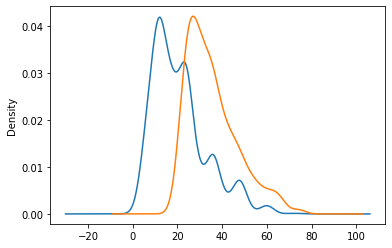

In [19]:
df_short["duration"].plot.kde()
df_short["age"].plot.kde()

#### Splitting the data

We split our data set into training and test data. With the k variable we can easily control the size of the two sets. 

In [20]:
k = 10
train_size = int((len(df_short)*(k-1))/k)

train_df_fair, test_df_fair = df_short[:train_size], df_short[train_size:]
train_df_short, test_df_short = df_short[:train_size], df_short[train_size:]
train_score, test_score = score_short[:train_size], score_short[train_size:]
test_score.shape

(100,)

### Calculating Probabilities according to our causal model

#### Calculating marginal probabilities

In [21]:
age_probs = train_df_short.groupby('age').size().div(len(train_df_short))
foreign_probs = train_df_short.groupby('foreign worker').size().div(len(train_df_short))
amount_probs = train_df_short.groupby('credit amount').size().div(len(train_df_short))
sex_probs = train_df_short.groupby('sex').size().div(len(train_df_short))
employment_probs = train_df_short.groupby('employment (since)').size().div(len(train_df_short))
job_probs = train_df_short.groupby('job').size().div(len(train_df_short))

#### Calculating interventional probabilities

We have 'sex' as protected attributed, 'employment (since)' as proxy. We do our intervention on the proxy variable and calculate the probabilities.

Thanks to the definition of interventions this boils down to the conditional probabilities.

$P(\text{foreign worker} \mid do(P = p)) = P(\text{foreign worker} \mid P = p) = P(\text{foreign worker})$

In [22]:
foreign_intervention_probs = pd.DataFrame({'prob' : foreign_probs}).reset_index()
display(foreign_intervention_probs)

,foreign worker,prob
0,0,0.963333
1,1,0.036667


$P(\text{credit amount} \mid do(P = p)) = \sum\limits_x P(\text{credit amount} \mid P = p, \text{job} = x) P(\text{job} = x)$

In [23]:
amount_intervention_probs = train_df_short.groupby(['credit amount', 'employment (since)', 'job']).size().div(len(train_df_short))
employment_job_probs = train_df_short.groupby(['employment (since)', 'job']).size().div(len(train_df_short))
amount_intervention_probs = amount_intervention_probs.div(employment_job_probs, axis=0)
amount_intervention_probs = amount_intervention_probs.mul(job_probs, axis=0, level='job')
amount_intervention_probs = pd.DataFrame({'prob' : amount_intervention_probs}).reset_index()
display(amount_intervention_probs)

,employment (since),job,credit amount,prob
0,0,0,672,0.001587
1,0,0,750,0.001587
2,0,0,926,0.001587
3,0,0,1098,0.001587
4,0,0,1175,0.001587
...,...,...,...,...
886,4,3,12579,0.003185
887,4,3,12680,0.003185
888,4,3,13756,0.003185
889,4,3,14318,0.003185


$P(\text{age} \mid do(P = p)) = P(\text{age} \mid P = p)$

In [24]:
age_intervention_probs = train_df_short.groupby(['age', 'employment (since)']).size().div(len(train_df_short))
age_intervention_probs = age_intervention_probs.div(employment_probs, axis=0, level='employment (since)')
age_intervention_probs = pd.DataFrame({'prob' : age_intervention_probs}).reset_index()
display(age_intervention_probs)

,age,employment (since),prob
0,19,1,0.013158
1,20,1,0.013158
2,20,2,0.019672
3,20,3,0.012346
4,20,4,0.013100
...,...,...,...
183,70,0,0.019231
184,74,2,0.006557
185,74,3,0.006173
186,74,4,0.004367


$P(\text{sex} \mid do(P = p)) = P(\text{sex} \mid P = p)$

In [25]:
sex_intervention_probs = train_df_short.groupby(['sex', 'employment (since)']).size().div(len(train_df_short))
sex_intervention_probs = sex_intervention_probs.div(employment_probs, axis=0, level='employment (since)')
sex_intervention_probs = pd.DataFrame({'prob' : sex_intervention_probs}).reset_index()
display(sex_intervention_probs)

,sex,employment (since),prob
0,0,0,0.615385
1,0,1,0.486842
2,0,2,0.691803
3,0,3,0.716049
4,0,4,0.807860
5,1,0,0.384615
6,1,1,0.513158
7,1,2,0.308197
8,1,3,0.283951
9,1,4,0.192140


$P(\text{credit history} \mid do(P = p)) = \sum\limits_x P(\text{credit history} \mid P = p, \text{age} = x) P(\text{age} = x)$

In [26]:
history_intervention_probs = train_df_short.groupby(['credit history', 'age', 'employment (since)']).size().div(len(train_df_short))
employment_age_probs = train_df_short.groupby(['employment (since)', 'age']).size().div(len(train_df_short))
history_intervention_probs = history_intervention_probs.div(employment_age_probs, axis=0)
history_intervention_probs = history_intervention_probs.mul(age_probs, axis=0, level='age')
history_intervention_probs = pd.DataFrame({'prob' : history_intervention_probs}).reset_index()
display(history_intervention_probs)

,age,employment (since),credit history,prob
0,19,1,2,0.002222
1,20,1,2,0.014444
2,20,2,2,0.012037
3,20,2,3,0.002407
4,20,3,2,0.014444
...,...,...,...,...
407,74,2,4,0.004444
408,74,3,2,0.004444
409,74,4,1,0.004444
410,75,0,2,0.001111


$P(\text{duration} \mid do(P = p) = \sum\limits_{x,y} P(\text{duration} \mid \text{job} = x, \text{credit amount} = y) P(\text{job} = x) P(\text{credit amount} = y)$

In [27]:
duration_intervention_probs = train_df_short.groupby(['duration', 'credit amount', 'job']).size().div(len(train_df_short))
#amount_jobs_probs = train_df_short.groupby(['credit amount', 'job']).size().div(len(train_df_short))
#duration_intervention_probs = duration_intervention_probs.div(amount_jobs_probs, axis=0)
#duration_intervention_probs = duration_intervention_probs.mul(job_probs, axis=0, level='job')
#duration_intervention_probs = duration_intervention_probs.mul(amount_probs, axis=0, level='credit amount')
duration_intervention_probs = pd.DataFrame({'prob' : duration_intervention_probs}).reset_index()
display(duration_intervention_probs)

,duration,credit amount,job,prob
0,4,601,1,0.001111
1,4,1494,1,0.001111
2,4,1503,1,0.001111
3,4,1544,1,0.001111
4,4,3380,2,0.001111
...,...,...,...,...
894,60,13756,3,0.001111
895,60,14027,3,0.001111
896,60,14782,3,0.001111
897,60,15653,2,0.001111


$P(\text{job} \mid do(P = p)) = \sum\limits_x P(\text{job} \mid P = p, \text{age} = x) P(\text{age} = x)$

In [28]:
job_intervention_probs = train_df_short.groupby(['job', 'employment (since)', 'age']).size().div(len(train_df_short))
employment_age_probs = train_df_short.groupby(['employment (since)', 'age']).size().div(len(train_df_short))
job_intervention_probs = job_intervention_probs.div(employment_age_probs, axis=0)
job_intervention_probs = job_intervention_probs.mul(age_probs, axis=0, level='age')
job_intervention_probs = pd.DataFrame({'prob' : job_intervention_probs}).reset_index()
display(job_intervention_probs)

,employment (since),age,job,prob
0,0,22,2,0.025556
1,0,23,0,0.036667
2,0,23,2,0.012222
3,0,24,0,0.045556
4,0,25,0,0.041111
...,...,...,...,...
335,4,64,1,0.003333
336,4,65,2,0.005556
337,4,66,3,0.005556
338,4,67,2,0.003333


### Calculate Expectations for every feature

In [29]:
expectation_foreign = sum(foreign_intervention_probs["foreign worker"] * foreign_intervention_probs["prob"])
expectation_foreign

0.03666666666666667

In [30]:
expectation_amount = amount_intervention_probs.copy()
expectation_amount["prob"] = expectation_amount["credit amount"] * expectation_amount["prob"]
del expectation_amount["credit amount"]
del expectation_amount["job"]

expectation_amount = expectation_amount.groupby(["employment (since)"]).sum()
expectation_amount

,prob
employment (since),
0,2604.623968
1,3015.793594
2,3289.571727
3,3483.322342
4,2968.873498


In [31]:
expectation_age = age_intervention_probs.copy()
expectation_age["prob"] = expectation_age["age"] * expectation_age["prob"]
del expectation_age["age"]

expectation_age = expectation_age.groupby(["employment (since)"]).sum()
expectation_age

,prob
employment (since),
0,41.500000
1,29.828947
2,33.019672
3,33.555556
4,42.733624


In [32]:
expectation_sex = sex_intervention_probs.copy()
expectation_sex["prob"] = expectation_sex["sex"] * expectation_sex["prob"]
del expectation_sex["sex"]

expectation_sex = expectation_sex.groupby(["employment (since)"]).sum()
expectation_sex

,prob
employment (since),
0,0.384615
1,0.513158
2,0.308197
3,0.283951
4,0.192140


In [33]:
expectation_history = history_intervention_probs.copy()
expectation_history["prob"] = expectation_history["credit history"] * expectation_history["prob"]
del expectation_history["credit history"]
del expectation_history["age"]

expectation_history = expectation_history.groupby(["employment (since)"]).sum()
expectation_history

,prob
employment (since),
0,1.826111
1,1.982768
2,2.306043
3,2.384428
4,2.556109


In [34]:
expectation_duration = sum(duration_intervention_probs["duration"] * duration_intervention_probs["prob"])
expectation_duration

20.725555555555555

In [35]:
expectation_job = job_intervention_probs.copy()
expectation_job["prob"] = job_intervention_probs["job"] * job_intervention_probs["prob"]
del expectation_job["job"]
del expectation_job["age"]

expectation_job = expectation_job.groupby(["employment (since)"]).sum()
expectation_job

,prob
employment (since),
0,1.422222
1,1.522895
2,1.700017
3,1.743421
4,1.943816


In [36]:
train_df_fair

,duration,credit history,credit amount,employment (since),age,job,foreign worker,sex
0,6,4,1169,4,67,2,0,0
1,48,2,5951,2,22,2,0,1
2,12,4,2096,3,49,1,0,0
3,42,2,7882,3,45,2,0,0
4,24,3,4870,2,53,2,0,0
...,...,...,...,...,...,...,...,...
895,36,3,8947,3,31,3,0,0
896,21,2,2606,1,28,3,0,1
897,12,4,1592,3,35,2,1,1
898,15,2,2186,3,33,1,0,1


In [37]:
train_df_fair.loc[:,"foreign worker"] = train_df_fair.loc[:,"foreign worker"].sub(expectation_foreign, axis=0)
train_df_fair.loc[:,"duration"] = train_df_fair.loc[:,"duration"].sub(expectation_duration, axis=0)

for index, row in expectation_amount.iterrows():
    mask = (train_df_fair.loc[:,"employment (since)"] == row.name)
    valid = train_df_fair[mask]
    train_df_fair.loc[mask, "age"] = valid["credit amount"] - row[0]

for index, row in expectation_history.iterrows():
    mask = (train_df_fair.loc[:,"employment (since)"] == row.name)
    valid = train_df_fair[mask]
    train_df_fair.loc[mask, "age"] = valid["credit history"] - row[0]
    
for index, row in expectation_age.iterrows():
    mask = (train_df_fair.loc[:,"employment (since)"] == row.name)
    valid = train_df_fair[mask]
    train_df_fair.loc[mask, "age"] = valid["age"] - row[0]

for index, row in expectation_sex.iterrows():
    mask = (train_df_fair.loc[:,"employment (since)"] == row.name)
    valid = train_df_fair[mask]
    train_df_fair.loc[mask, "sex"] = valid["sex"] - row[0]

for index, row in expectation_job.iterrows():
    mask = (train_df_fair.loc[:,"employment (since)"] == row.name)
    valid = train_df_fair[mask]
    train_df_fair.loc[mask, "job"] = valid["job"] - row[0]
    
    
train_df_fair

/Users/julian/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,duration,credit history,credit amount,employment (since),age,job,foreign worker,sex
0,-14.725556,4,1169,4,-41.289733,0.056184,-0.036667,-0.192140
1,27.274444,2,5951,2,-33.325715,0.299983,-0.036667,0.691803
2,-8.725556,4,2096,3,-31.939984,-0.743421,-0.036667,-0.283951
3,21.274444,2,7882,3,-33.939984,0.256579,-0.036667,-0.283951
4,3.274444,3,4870,2,-32.325715,0.299983,-0.036667,-0.308197
...,...,...,...,...,...,...,...,...
895,15.274444,3,8947,3,-32.939984,1.256579,-0.036667,-0.283951
896,0.274444,2,2606,1,-29.811715,1.477105,-0.036667,0.486842
897,-8.725556,4,1592,3,-31.939984,0.256579,0.963333,0.716049
898,-5.725556,2,2186,3,-33.939984,-0.743421,-0.036667,0.716049


In [38]:
test_df_fair.loc[:,"foreign worker"] = test_df_fair.loc[:,"foreign worker"].sub(expectation_foreign, axis=0)
test_df_fair.loc[:,"duration"] = test_df_fair.loc[:,"duration"].sub(expectation_duration, axis=0)

for index, row in expectation_amount.iterrows():
    mask = (test_df_fair.loc[:,"employment (since)"] == row.name)
    valid = test_df_fair[mask]
    test_df_fair.loc[mask, "age"] = valid["credit amount"] - row[0]

for index, row in expectation_history.iterrows():
    mask = (test_df_fair.loc[:,"employment (since)"] == row.name)
    valid = test_df_fair[mask]
    test_df_fair.loc[mask, "age"] = valid["credit history"] - row[0]
    
for index, row in expectation_age.iterrows():
    mask = (test_df_fair.loc[:,"employment (since)"] == row.name)
    valid = test_df_fair[mask]
    test_df_fair.loc[mask, "age"] = valid["age"] - row[0]

for index, row in expectation_sex.iterrows():
    mask = (test_df_fair.loc[:,"employment (since)"] == row.name)
    valid = test_df_fair[mask]
    test_df_fair.loc[mask, "sex"] = valid["sex"] - row[0]

for index, row in expectation_job.iterrows():
    mask = (test_df_fair.loc[:,"employment (since)"] == row.name)
    valid = test_df_fair[mask]
    test_df_fair.loc[mask, "job"] = valid["job"] - row[0]
    
test_df_fair

/Users/julian/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,duration,credit history,credit amount,employment (since),age,job,foreign worker,sex
900,-4.725556,4,2625,4,-41.289733,0.056184,-0.036667,-0.192140
901,-0.725556,4,3485,1,-27.811715,0.477105,-0.036667,-0.513158
902,15.274444,4,10477,4,-41.289733,0.056184,-0.036667,-0.192140
903,-5.725556,2,1386,2,-33.325715,0.299983,-0.036667,-0.308197
904,3.274444,2,1278,4,-43.289733,1.056184,-0.036667,-0.192140
...,...,...,...,...,...,...,...,...
995,-8.725556,2,1736,3,-33.939984,-0.743421,-0.036667,0.716049
996,9.274444,2,3857,2,-33.325715,1.299983,-0.036667,-0.308197
997,-8.725556,2,804,4,-43.289733,0.056184,-0.036667,-0.192140
998,24.274444,2,1845,2,-33.325715,0.299983,-0.036667,-0.308197


In [39]:
cv = KFold(n_splits=10)
estimator = LogisticRegression()
clf_fair = GridSearchCV(estimator=estimator, param_grid={'C':np.logspace(-4, 2, num=10)}, cv=cv)
clf_fair.fit(train_df_fair, train_score)

clf_short = GridSearchCV(estimator=estimator, param_grid={'C':np.logspace(-4, 2, 10)}, cv=cv)
clf_short.fit(train_df_short, train_score)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])})

In [40]:
best_fair = clf_fair.best_estimator_
best_short = clf_short.best_estimator_

In [41]:
print(np.mean(best_fair.predict_proba(test_df_fair.loc[test_df_short['sex'] == 1]), axis=0))
print(np.mean(best_fair.predict_proba(test_df_fair.loc[test_df_short['sex'] == 0]), axis=0))

[0.62770432 0.37229568]
[0.68320051 0.31679949]


In [42]:
print(np.mean(best_short.predict_proba(test_df_short.loc[test_df_short['sex'] == 1]), axis=0))
print(np.mean(best_short.predict_proba(test_df_short.loc[test_df_short['sex'] == 0]), axis=0))

[0.64057576 0.35942424]
[0.68875553 0.31124447]


### Calculate Statistical Fairness Criteria

In [43]:
fair_predictions = best_fair.predict(test_df_fair)
short_predictions = best_short.predict(test_df_short)

(female_score_idx, ) = np.where(test_df_short.loc[:,'sex'] == 1)
(male_score_idx, ) = np.where(test_df_short.loc[:,'sex'] == 0)

male_score = test_score[male_score_idx]
female_score = test_score[female_score_idx]

male_good_mask = (male_score == 1)
male_bad_mask = (male_good_mask == False)
female_good_mask = (female_score == 1)
female_bad_mask = (female_good_mask == False)

#### Equalized Odds

In [44]:
male_predictions = fair_predictions[male_score_idx]
female_predictions = fair_predictions[female_score_idx]

male_good_predictions = male_predictions[male_good_mask]
male_bad_predictions = male_predictions[male_bad_mask]
female_good_predictions = female_predictions[female_good_mask]
female_bad_predictions = female_predictions[female_bad_mask]

print(len(male_good_predictions[(male_good_predictions == 1)]) / len(male_good_predictions))
print(len(male_bad_predictions[(male_bad_predictions == 1)]) / len(male_bad_predictions))
print(len(female_good_predictions[(female_good_predictions == 1)]) / len(female_good_predictions))
print(len(female_bad_predictions[(female_bad_predictions == 1)]) / len(female_bad_predictions))

0.9166666666666666
0.6666666666666666
0.9
0.625


In [45]:
male_predictions = short_predictions[male_score_idx]
female_predictions = short_predictions[female_score_idx]

male_good_predictions = male_predictions[male_good_mask]
male_bad_predictions = male_predictions[male_bad_mask]
female_good_predictions = female_predictions[female_good_mask]
female_bad_predictions = female_predictions[female_bad_mask]

print(len(male_good_predictions[(male_good_predictions == 1)]) / len(male_good_predictions))
print(len(male_bad_predictions[(male_bad_predictions == 1)]) / len(male_bad_predictions))
print(len(female_good_predictions[(female_good_predictions == 1)]) / len(female_good_predictions))
print(len(female_bad_predictions[(female_bad_predictions == 1)]) / len(female_bad_predictions))

0.9375
0.75
0.95
0.625


#### Treatment equality

In [46]:
male_predictions = fair_predictions[male_score_idx]
female_predictions = fair_predictions[female_score_idx]

male_good_predictions = male_predictions[male_good_mask]
male_bad_predictions = male_predictions[male_bad_mask]
female_good_predictions = female_predictions[female_good_mask]
female_bad_predictions = female_predictions[female_bad_mask]

male_false_positives = np.count_nonzero(male_bad_predictions == 1)
male_false_negatives = np.count_nonzero(male_good_predictions == 2)
female_false_positives = np.count_nonzero(female_bad_predictions == 1)
female_false_negatives = np.count_nonzero(female_good_predictions == 2)

print(male_false_negatives/male_false_positives)
print(female_false_negatives/female_false_positives)

0.25
0.4


In [47]:
male_predictions = short_predictions[male_score_idx]
female_predictions = short_predictions[female_score_idx]

male_good_predictions = male_predictions[male_good_mask]
male_bad_predictions = male_predictions[male_bad_mask]
female_good_predictions = female_predictions[female_good_mask]
female_bad_predictions = female_predictions[female_bad_mask]

male_false_positives = np.count_nonzero(male_bad_predictions == 1)
male_false_negatives = np.count_nonzero(male_good_predictions == 2)
female_false_positives = np.count_nonzero(female_bad_predictions == 1)
female_false_negatives = np.count_nonzero(female_good_predictions == 2)

print(male_false_negatives/male_false_positives)
print(female_false_negatives/female_false_positives)

0.16666666666666666
0.2


#### Overall accuracy equality

In [48]:
male_predictions = fair_predictions[male_score_idx]
female_predictions = fair_predictions[female_score_idx]

print(len(male_predictions[(male_predictions == male_score)])/len(male_predictions))
print(len(female_predictions[(female_predictions == female_score)])/len(female_predictions))

0.7222222222222222
0.75


In [49]:
male_predictions = short_predictions[male_score_idx]
female_predictions = short_predictions[female_score_idx]

print(len(male_predictions[(male_predictions == male_score)])/len(male_predictions))
print(len(female_predictions[(female_predictions == female_score)])/len(female_predictions))

0.7083333333333334
0.7857142857142857


#### Prediction accuracy

In [50]:
print(len(fair_predictions[(fair_predictions == test_score)])/len(fair_predictions))
print(len(short_predictions[(short_predictions == test_score)])/len(short_predictions))

0.73
0.73
